# Integration
- __Numerical Methods__
- __Numerical Integration with SciPy__
- __Tabulated Integrand__
- __Multiple Integration__
- __Symbolic & Arbitrary-Precision Integration__
- __Line Integrals__
- __Integral Transforms__

* Main focus: numerical integration (aka "quadrature").

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
import numpy as np
from scipy import integrate
import sympy
sympy.init_printing()

### Simpson's rule
* Definite integrals - interpreted as area between integrand curve and x axis:

![interpretation-as-area-between-curve-and-x-axis](pics/ch08-numerical-integration-example.png)

* Strategy for evaluating integral I(f): write it as discrete sum that approximates value of integral. ("n-point quadrature rule".)
* Quadrature rules derived from f(x) interpolations along interval [a,b].
* __Midpoint rule__: using 0th-order polynomial (constant value) of midpoint.
* __Trapezoid rule__: using 1st-order polynomial, evalated at endpoints.
* __Simpson's rule__: using 2nd-order polynomial, midpoint & endpoints.

In [3]:
a, b, X = sympy.symbols("a, b, x")
f = sympy.Function("f")

In [4]:
x = a, (a+b)/2, b # simpson's rule

In [5]:
# weight factors
w = [sympy.symbols("w_%d" % i) 
     for i in range(len(x))] 
w

In [6]:
# quadrature rule
q_rule = sum([w[i] * f(x[i]) 
              for i in range(len(x))])
q_rule

In [7]:
# using lambda to create symbolics for basis functions
phi = [sympy.Lambda(X, X**n) 
       for n in range(len(x))]
phi

In [8]:
eqs = [q_rule.subs(f, phi[n]) 
       - sympy.integrate(phi[n](X), (X, a, b)) 
       for n in range(len(phi))]
eqs

In [9]:
# solves for weight factors
w_sol = sympy.solve(eqs, w); w_sol

In [10]:
q_rule.subs(w_sol).simplify()

### Numerical Integration w/ SciPy
* Two types of quadrature routines:

1) accepts integrand as Python function using a __Gaussian__ quadrature - *quad(), quadrature(), fixed_quad()*)

2) __Newton-Cotes methods__: accepts arrays of integrand samples at given points - *trapz(), simps(), romb()*)

### Simple integration example

In [11]:
def f(x):
    return np.exp(-x**2)

In [12]:
# integrate.quad(function, upper limit, lower limit)
# return estimated integral & abs error
# error tolerances can be set using epsabs, epsrel keywords
val, err = integrate.quad(f, -1, 1)
val, err

### Extra arguments

In [13]:
def f(x, a, b, c):
    return a * np.exp(-((x-b)/c)**2)

In [14]:
val, err = integrate.quad(f, -1, 1, args=(1, 2, 3))
val, err

### Reshuffle arguments

In [15]:
from scipy.special import jv # zeroth-order bessel function

In [16]:
val, err = integrate.quad(lambda x: jv(0, x), 0, 5)
val, err

### Infinite limits 

In [17]:
f = lambda x: np.exp(-x**2)

In [18]:
val, err = integrate.quad(f, -np.inf, np.inf)
val, err

### Singularities
* quadrature() & fixed_quad() functions only support finite integration limits.

In [19]:
f = lambda x: 1/np.sqrt(abs(x))

In [20]:
a, b = -1, 1

In [21]:
# this integral diverges at x=0. quad() can't handle it.
integrate.quad(f, a, b)

<ipython-input-19-cb08fa3913fe>:1: RuntimeWarning: divide by zero encountered in double_scalars
  f = lambda x: 1/np.sqrt(abs(x))


In [22]:
# to avoid problem points, use points keyword
integrate.quad(f, a, b, points=[0])

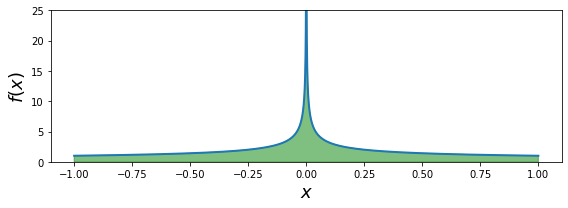

In [23]:
# visualize to see what's going on
fig, ax = plt.subplots(figsize=(8, 3))

x = np.linspace(a, b, 10000)
ax.plot(x, f(x), lw=2)
ax.fill_between(x, f(x), color='green', alpha=0.5)
ax.set_xlabel("$x$", fontsize=18)
ax.set_ylabel("$f(x)$", fontsize=18)
ax.set_ylim(0, 25)

fig.tight_layout()
fig.savefig("ch8-diverging-integrand.pdf")

### Tabulated integrand
* use case: integrand that is specified only at predetermined points. (ie, not using a Python function that can be evaluated at any point.)

In [24]:
f = lambda x: np.sqrt(x)

In [25]:
a, b = 0, 2

In [26]:
x = np.linspace(a, b, 25)

In [27]:
y = f(x)

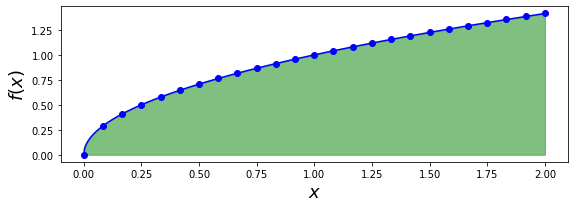

In [28]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(x, y, 'bo')
xx = np.linspace(a, b, 500)
ax.plot(xx, f(xx), 'b-')
ax.fill_between(xx, f(xx), color='green', alpha=0.5)
ax.set_xlabel(r"$x$", fontsize=18)
ax.set_ylabel(r"$f(x)$", fontsize=18)
fig.tight_layout()
fig.savefig("ch8-tabulated-integrand.pdf")

In [29]:
# trapezoid method
val_trapz = integrate.trapz(y, x)
val_trapz

In [30]:
# simpson's rule
val_simps = integrate.simps(y, x)
val_simps

In [31]:
# find error estimates by computing integral & comparising to above estimate
val_exact = 2.0/3.0 * (b-a)**(3.0/2.0)

val_exact, (val_exact-val_trapz), (val_exact-val_simps)

* We can't ask trapz or simps to find more accurate answers unless more samples are given, or a higher-order method is used.
* romb() function helps -- implementation of Romberg method

In [32]:
x = np.linspace(a, b, 1 + 2**6)
len(x)

In [33]:
y = f(x)

In [34]:
val_exact - integrate.romb(y, dx=(x[1]-x[0]))

In [35]:
val_exact - integrate.simps(y, dx=x[1]-x[0])

## Multiple integration
- __dblquad__ and __tplquad__ functions available in SciPy.

In [36]:
def f(x):
    return np.exp(-x**2)

In [37]:
%time integrate.quad(f, a, b)

CPU times: user 106 µs, sys: 0 ns, total: 106 µs
Wall time: 109 µs


In [38]:
def f(x, y):
    return np.exp(-x**2-y**2)

In [39]:
a, b = 0, 1

In [40]:
g = lambda x: 0
h = lambda x: 1

In [41]:
integrate.dblquad(f, a, b, g, h)

In [42]:
integrate.dblquad(
    lambda x, y: np.exp(-x**2-y**2), 
    0, 1, 
    lambda x: 0, 
    lambda x: 1)

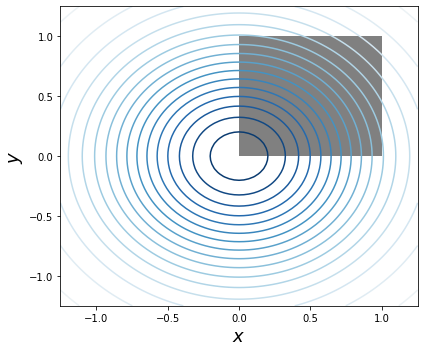

In [43]:
fig, ax = plt.subplots(figsize=(6, 5))

x = y = np.linspace(-1.25, 1.25, 75)
X, Y = np.meshgrid(x, y)

c = ax.contour(X, Y, f(X, Y), 15, cmap=mpl.cm.RdBu, vmin=-1, vmax=1)

bound_rect = plt.Rectangle((0, 0), 1, 1,
                           facecolor="grey")
ax.add_patch(bound_rect)

ax.axis('tight')
ax.set_xlabel('$x$', fontsize=18)
ax.set_ylabel('$y$', fontsize=18)

fig.tight_layout()
fig.savefig("ch8-multi-dim-integrand.pdf")

In [44]:
# because g&h are functions,
# we can find integrals with x-dependent integration limits along y.
integrate.dblquad(
    f, 
    0, 1, 
    lambda x: -1+x, 
    lambda x: 1-x)

### triple integrals

In [45]:
def f(x, y, z):
    return np.exp(-x**2 - y**2 - z**2)

In [46]:
integrate.tplquad(f, 0, 1, 
                  lambda x : 0, 
                  lambda x : 1, 
                  lambda x, y : 0, 
                  lambda x, y : 1)

In [47]:
integrate.nquad(f, [(0, 1), (0, 1), (0, 1)])

### Arbitrary number of integrations
* Computational complexity grows very quickly.

In [48]:
def f(*args):
    return  np.exp(-np.sum(np.array(args)**2))

In [49]:
%time integrate.nquad(f, [(0,1)] * 1)

CPU times: user 155 µs, sys: 91 µs, total: 246 µs
Wall time: 248 µs


In [50]:
%time integrate.nquad(f, [(0,1)] * 2)

CPU times: user 7.03 ms, sys: 0 ns, total: 7.03 ms
Wall time: 6.81 ms


In [51]:
%time integrate.nquad(f, [(0,1)] * 3)

CPU times: user 79.4 ms, sys: 0 ns, total: 79.4 ms
Wall time: 78.1 ms


In [52]:
%time integrate.nquad(f, [(0,1)] * 4)

CPU times: user 1.27 s, sys: 0 ns, total: 1.27 s
Wall time: 1.27 s


In [53]:
%time integrate.nquad(f, [(0,1)] * 5)

CPU times: user 26.9 s, sys: 110 ms, total: 27 s
Wall time: 27.3 s


## Symbolic and multi-precision quadrature

In [55]:
x = sympy.symbols("x")

In [56]:
f = 2 * sympy.sqrt(1-x**2)

In [57]:
a, b = -1, 1

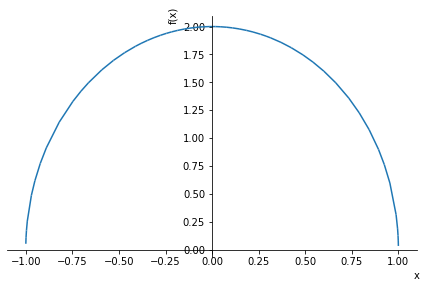

In [58]:
sympy.plot(f, (x, -2, 2));

In [59]:
val_sym = sympy.integrate(f, (x, a, b))
val_sym

### Sympy mpath library
- alternate method of numerical quadrature using arbitrary-precisin math
- much slower than floating-point math, but better precision than SciPy quadrature funcs.

In [60]:
import mpmath as mpmath

In [61]:
mpmath.mp.dps = 75 # number of digits of precision

In [62]:
# need mpmath-compatible python function as integrand.
f_mpmath = sympy.lambdify(x, f, 'mpmath')

In [63]:
# compute integral & display result
val = mpmath.quad(f_mpmath, (a, b))
sympy.sympify(val)

In [64]:
# compare result with known value. error sufficiently small?
sympy.N(val_sym, mpmath.mp.dps+1) - val

In [65]:
%timeit mpmath.quad(f_mpmath, [a, b])

3.51 ms ± 58.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [66]:
f_numpy = sympy.lambdify(x, f, 'numpy')

In [67]:
%timeit integrate.quad(f_numpy, a, b)

330 µs ± 2.34 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Line integrals
- 1st argument = integrand (symPy expression)
- 2nd argument = symPy Curve object
- 3rd argument = list of integration variables

In [68]:
t, x, y = sympy.symbols("t, x, y")

In [69]:
C = sympy.Curve([sympy.cos(t), sympy.sin(t)], (t, 0, 2 * sympy.pi))

In [70]:
sympy.line_integrate(1, C, [x, y])

In [71]:
sympy.line_integrate(x**2 * y**2, C, [x, y])

### Integral transformations
* __integral transform__: accepts a function as input, returns another function.
* best when computed symbolically
* two examples: __laplace__ (differential equation into algebraic equation) and __fourier__ (time domain to frequency domain).

### Laplace transforms

In [72]:
s    = sympy.symbols("s")
a, t = sympy.symbols("a, t", positive=True)
f    = sympy.sin(a*t)

In [73]:
# compute transform
# returns tuple: result transform, value 'A' from convergence condition, any add'l conditions.

sympy.laplace_transform(f, t, s)

In [74]:
# if you want just the result function:
F = sympy.laplace_transform(f, t, s, noconds=True); F

In [75]:
# inverse transform (swap 's','t' arguments)
sympy.inverse_laplace_transform(F, s, t, noconds=True)

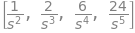

In [76]:
# sympy can find transforms for many elementary functions automatically
# ex: laplace transforms of polynomials

[sympy.laplace_transform(f, t, s, noconds=True) 
 for f in [t, t**2, t**3, t**4]]

In [77]:
# computing general results with arbitrary integer exponents
n = sympy.symbols(
    "n", integer=True, positive=True)

sympy.laplace_transform(t**n, t, s, noconds=True)

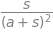

In [78]:
# laplace xform of composite expression
sympy.laplace_transform(
    (1 - a*t) * sympy.exp(-a*t), t, s, noconds=True)

### Fourier Transforms
* available functions: __fourier_transform()__, __inverse_fourier_transform()__

In [79]:
w = sympy.symbols("omega")

In [80]:
f = sympy.exp(-a*t**2)

In [81]:
F = sympy.fourier_transform(f, t, w); F

In [82]:
sympy.inverse_fourier_transform(F, w, t)